<a href="https://colab.research.google.com/github/Daria-Lytvynenko/ML_course/blob/main/HW_NLP_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [226]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [227]:
df = pd.read_csv('drive/MyDrive/ML_course/tweet_sentiment_train.csv/train.csv')

In [228]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [230]:
df.dropna(inplace=True)

### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [231]:
df.sentiment.value_counts(normalize=True)

,proportion
sentiment,
neutral,0.404549
positive,0.312300
negative,0.283151


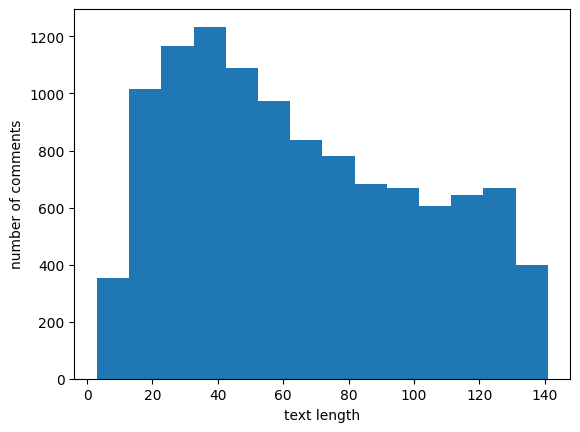

In [232]:
plt.hist(df[df.sentiment=='neutral']['text'].str.len(), bins=14)
plt.xlabel('text length')
plt.ylabel('number of comments');

Text(0.5, 1.0, 'negative')

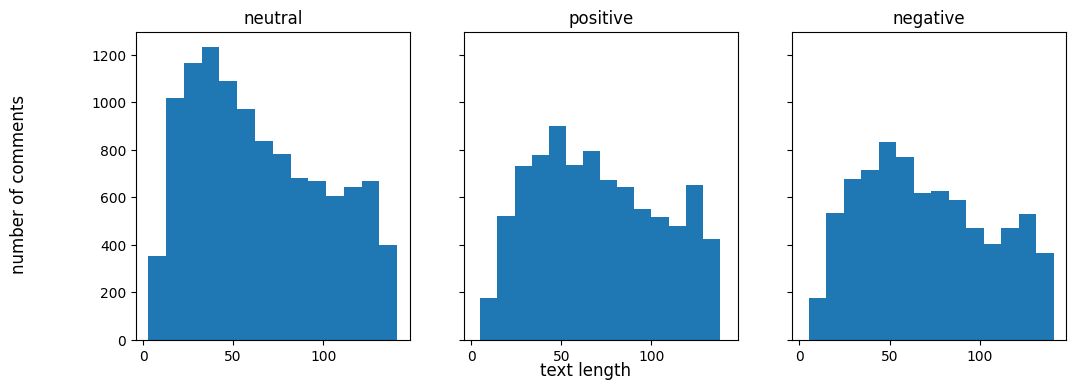

In [233]:
fig, ax=plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharex=True, sharey=True)
fig.supxlabel('text length')
fig.supylabel('number of comments')
ax[0].hist(df[df.sentiment=='neutral']['text'].str.len(), bins=14)
ax[0].set_title('neutral')
ax[1].hist(df[df.sentiment=='positive']['text'].str.len(), bins=14)
ax[1].set_title('positive')
ax[2].hist(df[df.sentiment=='negative']['text'].str.len(), bins=14)
ax[2].set_title('negative')

Найбільше коментарів, що містять близько 40 символів, розподіл зміщений вліво. Якщо окремо дивитись по типу коментарів, то видно, для всіх груп розподіл подібний.

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [234]:
from nltk.tokenize import word_tokenize, PunktSentenceTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

In [235]:
import nltk

In [236]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [237]:
detector=PunktSentenceTokenizer()

In [238]:
vect=CountVectorizer()
vect_fit=vect.fit(df.text)

In [239]:
vect.get_feature_names_out().shape

(26439,)

In [240]:
vectors=vect.transform(df.text)

In [241]:
stemmer=SnowballStemmer(language='english')

In [242]:
nltk.download('stopwords')
english_stopwords=stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [243]:
def tokenize(text):
  return [stemmer.stem(word) for word in word_tokenize(text)]

In [244]:
vectorizer=CountVectorizer(lowercase=True,
                           tokenizer=tokenize,
                           stop_words=english_stopwords,
                           max_features=1000)


In [245]:
vectorizer.fit(df['text'])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'m", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


CountVectorizer(max_features=1000,
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...],
                tokenizer=<function tokenize at 0x7d109997e160>)

In [246]:
inputs=vectorizer.transform(df.text)

In [247]:
inputs.shape

(27480, 1000)

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [248]:
target=df.iloc[:,-1].name

In [249]:
train_idx, test_idx=train_test_split(range(inputs.shape[0]), test_size=0.3, random_state=42)

In [250]:
X_train_bow=inputs[train_idx]
X_test_bow=inputs[test_idx]
y_train=df.iloc[train_idx, -1]
y_test=df.iloc[test_idx, -1]

In [251]:
X_train_bow

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 131730 stored elements and shape (19236, 1000)>

In [252]:
logreg=LogisticRegression(solver='saga', penalty='l1')

In [253]:
logreg.fit(X_train_bow, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(penalty='l1', solver='saga')

In [254]:
y_pred_train=logreg.predict(X_train_bow)

In [255]:
accuracy_score(y_train, y_pred_train)

0.6974422956955708

In [256]:
f1_score(y_train, y_pred_train, average='weighted')

0.6959987284948366

In [257]:
confusion_matrix(y_train, y_pred_train)

array([[3088, 1981,  356],
       [ 722, 6185,  867],
       [ 247, 1647, 4143]])

In [258]:
y_pred=logreg.predict(X_test_bow)

In [259]:
accuracy_score(y_test, y_pred)

0.675764192139738

In [260]:
f1_score(y_test, y_pred, average='weighted')

0.6732806031862594

In [261]:
confusion_matrix(y_test, y_pred)

array([[1230,  954,  172],
       [ 373, 2589,  381],
       [ 100,  693, 1752]])

In [291]:
tree=DecisionTreeClassifier(splitter='best', random_state=42, max_depth=10000)

In [292]:
tree.fit(X_train_bow, y_train)
tree_pred=tree.predict(X_test_bow)

In [293]:
accuracy_score(y_test, tree_pred)

0.6115963124696749

In [294]:
f1_score(y_test, tree_pred, average='weighted')

0.6110360469543595

In [266]:
confusion_matrix(y_test, y_pred)

array([[1230,  954,  172],
       [ 373, 2589,  381],
       [ 100,  693, 1752]])

In [267]:
import numpy as np

In [268]:
pred_test=pd.concat([y_test.reset_index(drop=True), pd.Series(y_pred, name='pred_class'), pd.DataFrame(logreg.predict_proba(X_test_bow), columns=['neg', 'neutr', 'pos']),
                      pd.Series(np.max(logreg.predict_proba(X_test_bow), axis=1), name='max_proba')], axis=1)

In [269]:
pred_test

,sentiment,pred_class,neg,neutr,pos,max_proba
0,positive,positive,0.170615,0.264174,0.565210,0.565210
1,negative,neutral,0.304782,0.491738,0.203480,0.491738
2,neutral,neutral,0.212532,0.524444,0.263024,0.524444
3,positive,neutral,0.167524,0.489943,0.342533,0.489943
4,neutral,neutral,0.300551,0.419745,0.279704,0.419745
...,...,...,...,...,...,...
8239,positive,positive,0.000791,0.005642,0.993567,0.993567
8240,neutral,neutral,0.289426,0.613843,0.096731,0.613843
8241,positive,positive,0.017660,0.042718,0.939622,0.939622
8242,negative,negative,0.717864,0.214755,0.067381,0.717864


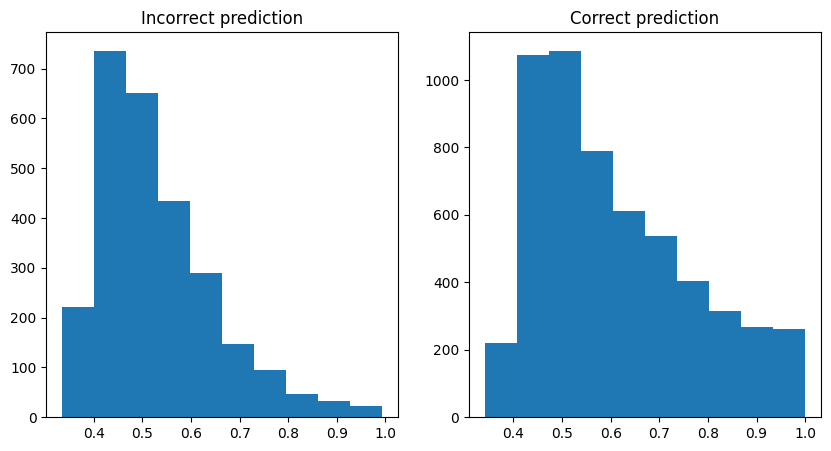

In [270]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].hist(pred_test[pred_test['sentiment']!=pred_test['pred_class']]['max_proba'])
ax[0].set_title('Incorrect prediction')
ax[1].hist(pred_test[pred_test['sentiment']==pred_test['pred_class']]['max_proba'])
ax[1].set_title('Correct prediction')
fig.show()

Значення метрики f1 на тестових даних 67,5%. Модель не дуже точна. З матриці видно, що модель багато зразків невірно відносить до нейтрального класу. З графіків розподілу ймовірностей видно, що на неправильно передбачених зразках модель не дуже впевнена і багато ймовірностей лежить в діапазоні 0.34-0.5, тоді як менше значень в дапазоні 0.7-1.0. Хоча і серед правильних передбачень велика к-сть зразків з ймовірністю до 0.5.

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [271]:
feat_importance=pd.DataFrame(logreg.coef_[0], index=vectorizer.get_feature_names_out(), columns=['imp'])

In [272]:
valuable_words=pd.concat([pd.DataFrame(feat_importance.sort_values(by='imp', ascending=True)[:30]).reset_index(drop=False),
                            pd.DataFrame(feat_importance.sort_values(by='imp', ascending=False)[:30]).reset_index(drop=False)], axis=1)

In [273]:
valuable_words

,index,imp,index,imp
0,love,-1.162601,sad,1.388060
1,thank,-1.060244,miss,1.290311
2,hope,-0.772432,sorri,1.164958
3,awesom,-0.761208,suck,1.131098
4,great,-0.734763,hate,1.103644
5,good,-0.703057,bore,0.943819
6,happi,-0.690398,hurt,0.902002
7,nice,-0.680182,sick,0.869061
8,lol,-0.562826,bad,0.862389
9,better,-0.524573,tire,0.689883


Загалом, перелік важливих слів виглядає логічно.

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [274]:
tfidf=TfidfVectorizer(lowercase=True,
                           tokenizer=tokenize,
                           stop_words=english_stopwords,
                           max_features=1000)

In [275]:
tfidf.fit(df['text'])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'m", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


TfidfVectorizer(max_features=1000,
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...],
                tokenizer=<function tokenize at 0x7d109997e160>)

In [276]:
input_tfidf=tfidf.transform(df['text'])
# X_test_tfidf=tfidf.transform(X_test_tfidf)

In [277]:
X_train_tfidf=input_tfidf[train_idx]
X_test_tfidf=input_tfidf[test_idx]

In [278]:
logreg=LogisticRegression(solver='saga', penalty='l1')

In [279]:
logreg.fit(X_train_tfidf, y_train)
pred_tfidf=logreg.predict(X_test_tfidf)
proba_tfidf=logreg.predict_proba(X_test_tfidf)

In [280]:
accuracy_score(y_test, pred_tfidf)

0.7002668607472101

In [281]:
f1_score(y_test, pred_tfidf, average='weighted')

0.699410597394245

In [282]:
confusion_matrix(y_test, pred_tfidf)

array([[1376,  824,  156],
       [ 412, 2556,  375],
       [  99,  605, 1841]])

In [283]:
feat_importance=pd.DataFrame(logreg.coef_[0], index=tfidf.get_feature_names_out(), columns=['imp'])

In [284]:
valuable_words=pd.concat([pd.DataFrame(feat_importance.sort_values(by='imp', ascending=True)[:30]).reset_index(drop=False),
                            pd.DataFrame(feat_importance.sort_values(by='imp', ascending=False)[:30]).reset_index(drop=False)], axis=1)

In [285]:
valuable_words

,index,imp,index,imp
0,awesom,-6.131650,sad,7.043490
1,love,-4.706614,stupid,6.277378
2,thank,-4.642379,fail,6.269774
3,glad,-3.875936,suck,6.254827
4,cute,-3.453022,miss,6.040319
5,welcom,-3.142139,hate,5.870983
6,hope,-3.080747,worst,5.839821
7,lol,-3.022451,sorri,5.510724
8,win,-2.843277,bore,5.440050
9,enjoy,-2.738726,headach,5.321398


### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [286]:
pred_test=pd.concat([y_test.reset_index(drop=True), pd.Series(pred_tfidf, name='pred_class'), pd.DataFrame(logreg.predict_proba(X_test_tfidf), columns=['neg', 'neutr', 'pos']),
                      pd.Series(np.max(logreg.predict_proba(X_test_tfidf), axis=1), name='max_proba')], axis=1)

In [287]:
predictions=pd.concat([df['text'][test_idx].reset_index(drop=True), pred_test], axis=1)

In [288]:
predictions[predictions['sentiment']!=predictions['pred_class']].head(30)

,text,sentiment,pred_class,neg,neutr,pos,max_proba
1,Sorry but there is no parking space. And I ju...,negative,neutral,0.254757,0.593252,0.151992,0.593252
8,"I bet its cool down in SR, huh? It`s not here...",neutral,negative,0.405916,0.382570,0.211515,0.405916
17,looking for new ideas for my blog,negative,neutral,0.211659,0.677098,0.111243,0.677098
21,I think they make you turn your phones off I...,negative,positive,0.118948,0.412260,0.468791,0.468791
26,Ugh - car got stolen sometime between yesterda...,negative,positive,0.066710,0.357682,0.575608,0.575608
29,where are ya headin to for your family vaca? ...,positive,neutral,0.157305,0.686316,0.156379,0.686316
38,they are a long way from the sea unless the...,positive,negative,0.735871,0.081250,0.182879,0.735871
42,i widddd but i`ll be on a bus to london & ...,negative,neutral,0.408977,0.454755,0.136269,0.454755
44,found any decently priced breakfast yet? i hop...,neutral,negative,0.461454,0.442330,0.096216,0.461454
49,Thinks he may have broken his nose at the show,negative,neutral,0.233280,0.596840,0.169880,0.596840


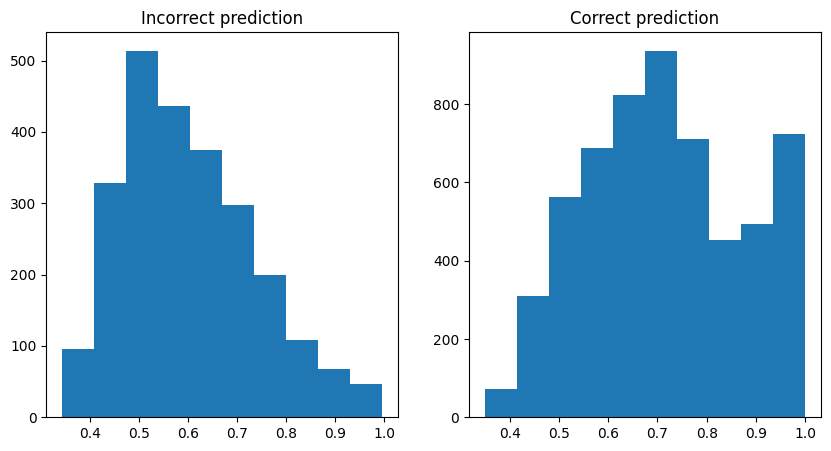

In [289]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].hist(pred_test[pred_test['sentiment']!=pred_test['pred_class']]['max_proba'])
ax[0].set_title('Incorrect prediction')
ax[1].hist(pred_test[pred_test['sentiment']==pred_test['pred_class']]['max_proba'])
ax[1].set_title('Correct prediction')
fig.show()

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model